In [1]:
from petsc4py import PETSc
from slepc4py import SLEPc

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from statfenics import covariance as cov

In [2]:
N_EIGENVALUES = 32
mesh = fe.IntervalMesh(1001, 0, 25)
V = fe.FunctionSpace(mesh, "CG", 1)

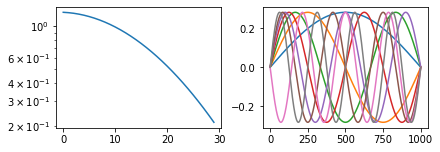

In [3]:
vals_hb, vecs_hb = cov.sq_exp_evd_hilbert(V, N_EIGENVALUES, scale=1., ell=0.5)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 2))
axs[0].semilogy(vals_hb)
axs[1].plot(vecs_hb[:, :8])
plt.show()

In [4]:
def boundary(x, on_boundary):
    return on_boundary

bc = fe.DirichletBC(V, fe.Constant(0), boundary)
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
a = fe.inner(fe.grad(u), fe.grad(v)) * fe.dx
A = fe.PETScMatrix()
fe.assemble(a, tensor=A)

M = fe.PETScMatrix()
fe.assemble(u * v * fe.dx, tensor=M)

if bc is not None:
    bc.apply(A)
    bc.apply(M)

M = M.mat()
A = A.mat()

M_scipy = csr_matrix(M.getValuesCSR()[::-1], shape=M.size)
A_scipy = -csr_matrix(A.getValuesCSR()[::-1], shape=A.size)

# use shift-invert mode in scipy
# faster and more stable than SLEPc
vals, vecs = eigsh(A_scipy, N_EIGENVALUES, M_scipy, sigma=1e-14)

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


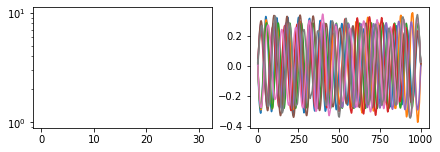

In [5]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 2))
axs[0].semilogy(vals)
axs[1].plot(vecs[:, :8])
plt.show()

In [6]:
E = SLEPc.EPS()
E.create()
E.setOperators(A, M)
E.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
E.setFromOptions()
E.setDimensions(nev=N_EIGENVALUES)
E.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_MAGNITUDE)
%timeit E.solve()

21.5 ns ± 0.0474 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [7]:
Print = PETSc.Sys.Print

Print()
Print("******************************")
Print("*** SLEPc Solution Results ***")
Print("******************************")
Print()

its = E.getIterationNumber()
Print("Number of iterations of the method: %d" % its)

eps_type = E.getType()
Print("Solution method: %s" % eps_type)

nev, ncv, mpd = E.getDimensions()
Print("Number of requested eigenvalues: %d" % nev)

tol, maxit = E.getTolerances()
Print("Stopping condition: tol=%.4g, maxit=%d" % (tol, maxit))


******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 96
Solution method: krylovschur
Number of requested eigenvalues: 32
Stopping condition: tol=1e-08, maxit=100


In [8]:
nconv = E.getConverged()
Print("Number of converged eigenpairs %d" % nconv)

Number of converged eigenpairs 34


In [9]:
# Create the results vectors
vr, wr = A.getVecs()
vi, wi = A.getVecs()

vals = []
vecs = np.zeros((vr.array_r.shape[0], 8))

Print()
Print("        k          ||Ax-kx||/||kx|| ")
Print("----------------- ------------------")
for i in range(8):
    k = E.getEigenpair(i, vr, vi)
    vals.append(k)
    
    error = E.computeError(i)
    if k.imag != 0.0:
        Print(" %9f%+9f j %12g" % (k.real, k.imag, error))
    else:
        Print(" %12f      %12g" % (k.real, error))
        
    vecs[:, i] = vr.array_r


        k          ||Ax-kx||/||kx|| 
----------------- ------------------
     0.015791       1.74573e-10
     0.063166       7.66581e-11
     0.142123       6.01915e-12
     0.252665       1.10301e-10
     0.394792       1.17942e-11
     0.568506       3.35751e-11
     0.773808       2.68845e-11
     1.000000       7.94599e-11


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


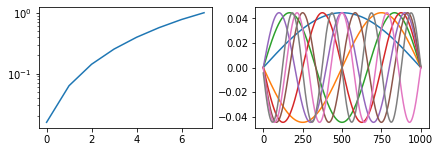

In [10]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 2))
axs[0].semilogy(vals)
axs[1].plot(vecs)
plt.show()

In [11]:
K_approx = vecs_hb @ (np.diag(vals_hb)) @ vecs_hb.T
K = cov.sq_exp_covariance(V.tabulate_dof_coordinates(),
                          scale=1., ell=0.5)

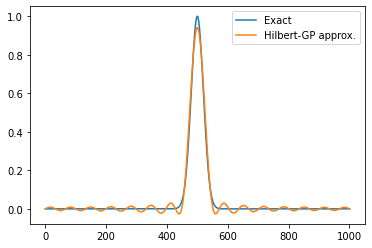

In [12]:
row = 500
plt.plot(K[row, :], label="Exact")
plt.plot(K_approx[row, :], label="Hilbert-GP approx.")
plt.legend()
plt.show()

## Unit square mesh comparison

Now we run the same tests for the case in which the mesh is given by a square:

In [13]:
N_EIGENVALUES = 32
mesh = fe.UnitSquareMesh(100, 100)
V = fe.FunctionSpace(mesh, "CG", 1)

def boundary(x, on_boundary):
    return on_boundary

bc = fe.DirichletBC(V, fe.Constant(0), boundary)
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
a = fe.inner(fe.grad(u), fe.grad(v)) * fe.dx
A = fe.PETScMatrix()
fe.assemble(a, tensor=A)

M = fe.PETScMatrix()
fe.assemble(u * v * fe.dx, tensor=M)

if bc is not None:
    bc.apply(A)
    bc.apply(M)

M = M.mat()
A = A.mat()

M_scipy = csr_matrix(M.getValuesCSR()[::-1], shape=M.size)
A_scipy = -csr_matrix(A.getValuesCSR()[::-1], shape=A.size)
vals_scipy, vecs_scipy = eigsh(A_scipy, N_EIGENVALUES, M_scipy, sigma=1e-14)

E = SLEPc.EPS()
E.create()
E.setOperators(A, M)
# E.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
E.setFromOptions()
E.setDimensions(nev=N_EIGENVALUES)
E.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_MAGNITUDE)
E.setTolerances(1e-12, 100000)
E.solve()

(10201, 2)
(10201, 32)


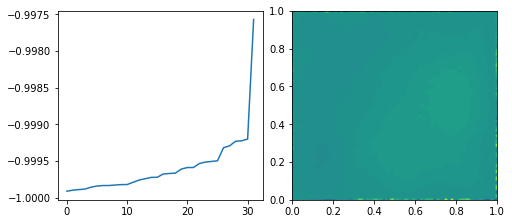

In [14]:
x = V.tabulate_dof_coordinates()
print(x.shape)
print(vecs_scipy.shape)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 3))
axs[0].plot(vals_scipy)
axs[1].tricontourf(x[:, 0], x[:, 1], vecs_scipy[:, 5], 64)
plt.show()

In [15]:
# Create the results vectors
vr, wr = A.getVecs()
vi, wi = A.getVecs()

vals = np.zeros((N_EIGENVALUES, ))
vecs = np.zeros((vr.array_r.shape[0], N_EIGENVALUES))

# Print()
# Print("        k          ||Ax-kx||/||kx|| ")
# Print("----------------- ------------------")
for i in range(N_EIGENVALUES):
    k = E.getEigenpair(i, vr, vi)
    vals[i] = np.real(k)
    
    error = E.computeError(i)
#     if k.imag != 0.0:
#         Print(" %9f%+9f j %12g" % (k.real, k.imag, error))
#     else:
#         Print(" %12f      %12g" % (k.real, error))
        
    vecs[:, i] = vr.array_r
    
# take values which are different up to 10^(-4) tolerance
vals = vals[np.abs(vals - 1.) / vals > 1e-4]
print(vals)

[ 19.74407947  49.36896108  49.38066474  79.03474405  98.79184465
  98.79189915 128.45116241 128.5498504  168.04081942 168.04719301
 178.04651758 197.82067104 197.82195069 247.28690641 247.67477993
 257.19952952 257.19957897 287.04737088 287.08210243 317.06423185
 336.86923964 336.8811927  366.34356415 366.34930843 396.31883026
 396.31955812 406.12763212]


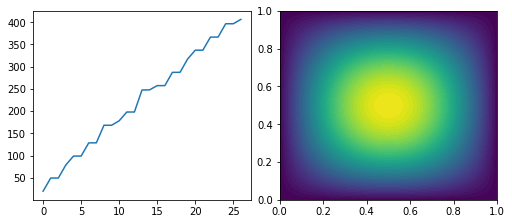

In [16]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 3))
axs[0].plot(vals)
axs[1].tricontourf(x[:, 0], x[:, 1], vecs[:, 5], 64)
plt.show()

In [17]:
vals_true = np.zeros(((N_EIGENVALUES // 2), (N_EIGENVALUES // 2)))
for i in range(1, N_EIGENVALUES // 2):
    for j in range(1, N_EIGENVALUES // 2):
        vals_true[i, j] = (np.pi**2 * (i**2 + j**2))
        
vals_true = np.sort(vals_true[vals_true != 0.].flatten())

print(vals_true[:len(vals)])
print(vals)
print(np.abs(vals - vals_true[:len(vals)]) / np.abs(vals))

[ 19.7392088   49.34802201  49.34802201  78.95683521  98.69604401
  98.69604401 128.30485721 128.30485721 167.78327482 167.78327482
 177.65287922 197.39208802 197.39208802 246.74011003 246.74011003
 256.60971443 256.60971443 286.21852763 286.21852763 315.82734083
 335.56654964 335.56654964 365.17536284 365.17536284 394.78417604
 394.78417604 404.65378044]
[ 19.74407947  49.36896108  49.38066474  79.03474405  98.79184465
  98.79189915 128.45116241 128.5498504  168.04081942 168.04719301
 178.04651758 197.82067104 197.82195069 247.28690641 247.67477993
 257.19952952 257.19957897 287.04737088 287.08210243 317.06423185
 336.86923964 336.8811927  366.34356415 366.34930843 396.31883026
 396.31955812 406.12763212]
[0.00024669 0.00042413 0.00066104 0.00098575 0.00096972 0.00097027
 0.00113899 0.00190582 0.00153263 0.0015705  0.00221087 0.00216652
 0.00217298 0.00221118 0.00377378 0.00229322 0.00229341 0.00288748
 0.00300811 0.00390107 0.00386705 0.00390239 0.00318881 0.00320444
 0.00387227 0.00

In [18]:
vals, vecs = cov.sq_exp_evd_hilbert(V, k=N_EIGENVALUES, scale=1., ell=0.5, bc="Dirichlet")

In [19]:
print(vals)

[1.33130260e-01 3.28122835e-03 3.27643156e-03 8.04592027e-05
 6.80809729e-06 6.80805091e-06 1.67076742e-07 1.65028344e-07
 1.18500396e-09 1.18406024e-09 3.39267582e-10 2.86461754e-11
 2.86415936e-11 5.91156562e-14 5.63178541e-14 1.71229199e-14
 1.71228141e-14 4.10424923e-16 4.08646948e-16 9.63194711e-18
 8.10146183e-19 8.08936621e-19 2.03468099e-20 2.03322055e-20
 4.79992825e-22 4.79949155e-22 1.40846539e-22]


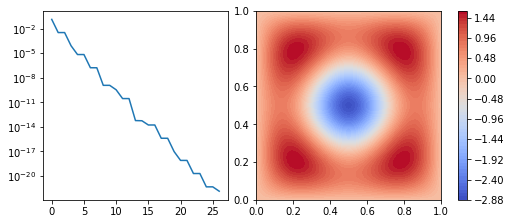

In [20]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 3))
axs[0].semilogy(vals)
im = axs[1].tricontourf(x[:, 0], x[:, 1], vecs[:, 5], 64, cmap="coolwarm")
plt.colorbar(im, ax=axs[1])
plt.show()